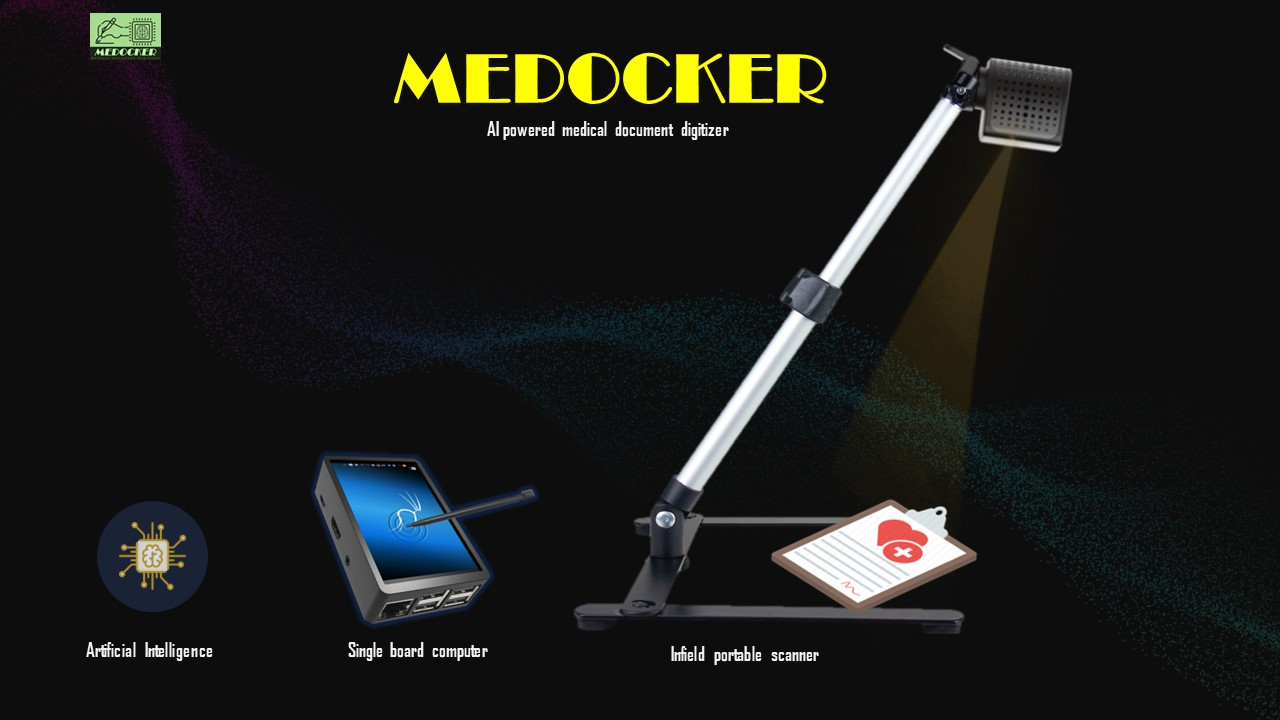

# *** MEDOCKER - AI powered medical document digitizer***


---



***Authors: Lauren Walker, Alexandar Vincent Paulraj.***

***University of Liverpool***

# **Check list**


---


 ***Folder & file names are important***
1. Upload template form named (***Medocker_template.jpg***) Click on paper with up arrow beneath files tab
2. Upload ***dataoutput*** csv file
3. Create folder and name it ***data***
4. Upload the scanned documents/images to the data folder by clicking the 3 black buttons to right of data folder
5. Click the play button in the below cells  ***1. Preparation. wait for green tick 2. Medocker*** wait for green tick
6. After it has run download the dataoutput csv file


In [ ]:
# 1. Preparation
!pip install transformers[torch]
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 14.4 MB/s 
     |████████████████████████████████| 7.6 MB 49.8 MB/s 
     |████████████████████████████████| 163 kB 74.3 MB/s 


Downloading:   0%|          | 0.00/228 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.23G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 2. Medocker
import cv2
from cv2 import COLOR_BGR2GRAY
import numpy as np
import os
import pandas as pd

# Setting region of interests# customisation
roi = [[(187,156),(697,216), 'text', 'Name'],
       [(186,368),(698,425), 'text', 'Medication'],
       [(187,524),(695,581), 'text', 'Disease'],
       [(377,272),(416,309), 'box', 'Male'],
       [(582,270),(622,310), 'box', 'Female']]

# Function for OCR
def ocr_image(src_img):
  pixel_values = processor(images=src_img, return_tensors="pt").pixel_values
  generated_ids = model.generate(pixel_values)
  return processor.batch_decode(generated_ids, skip_special_tokens=True)[0]


per=30 #percentage
pixelThreshold=120 #for box selection

#Template image read
imgQ = cv2.imread('Medcoker_template.jpg')
h,w,c=imgQ.shape
#imgQ =cv2.resize(imgQ, (w//3, h//3))

#Find features ins the templates and set key points
orb=cv2.ORB_create(1000)
kp1, des1=orb.detectAndCompute(imgQ,None)
imkp1=cv2.drawKeypoints(imgQ,kp1,None)
# cv2.imshow('Keypoint Image', imkp1)

#Set path folder containing scanned images
path='./data'
myPicList=os.listdir(path)
print(myPicList)

for j,y in enumerate(myPicList):
    img =cv2.imread(path +'/'+y)
    #cv2.imshow(y, img)
    kp2, des2 = orb.detectAndCompute(img, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.match(des2, des1)
    matches = sorted(matches, key=lambda x: x.distance)
    good = matches[:int(len(matches)*(per/100))]
    imgMatch = cv2.drawMatches(img,kp2,imgQ,kp1,good[:100],None, flags=2)
    #imgMatch = cv2.resize(imgMatch, (w //2, h //2))
    #cv2.imshow(y, imgMatch)

    srcPoints = np.float32([kp2[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dstPoints = np.float32([kp1[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    
    M, _ =cv2.findHomography(srcPoints,dstPoints,cv2.RANSAC,5.0)
    imgscan = cv2.warpPerspective(img,M,(w,h))
    #imgscan = cv2.resize(imgscan, (w //2, h //2))
    #cv2.imshow(y, imgscan)
    imgShow = imgscan.copy()
    imgMask = np.zeros_like(imgShow)
    
    myData = []
    print(f'__________Medocker in progress ________{j}')
    
    for x, r in enumerate(roi):
        cv2.rectangle(imgMask, ((r[0][0]),r[0][1]),((r[1][0]), r[1][1]),(0,255,0),cv2.FILLED)
        imgShow = cv2.addWeighted(imgShow, 0.99,imgMask,0.1,0)
        
        imgCrop = imgscan[r[0][1]:r[1][1], r[0][0]:r[1][0]]
        #cv2.imshow(str(x), imgCrop)
        
        if r[2] =='text':
            print(f'{r[3]} :{ocr_image(imgCrop)}')
            myData.append(ocr_image(imgCrop))
            
        if r[2] =='box':
            imgGray = cv2.cvtColor(imgCrop, COLOR_BGR2GRAY)
            imgThresh = cv2.threshold(imgGray,170,255, cv2.THRESH_BINARY_INV)[1]
            totalPixels = cv2.countNonZero(imgThresh)
            if totalPixels>pixelThreshold: totalPixels =1;
            else: totalPixels=0
            print(f'{r[3]}:{totalPixels}')
            myData.append(totalPixels)
    with open('dataoutput.csv', 'a+') as f:
        for data in myData:
            f.write((str(data)+ ','))
        f.write('\n')
            
                  
    #cv2.imshow(y+'2', imgShow)
#cv2.imshow('Original Image', imgQ)
#cv2.waitKey(0)

['4.jpg', '1.jpg', '3.jpg', '5.jpg', '2.jpg']


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


__________Medocker in progress ________0


/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1364: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Name :your test


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Medication :take rest


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Disease :nothing
Male:1
Female:0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


__________Medocker in progress ________1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Name :That patient


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Medication :4 Astrovastatin


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Disease :heart failure.
Male:1
Female:0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


__________Medocker in progress ________2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Name :Test patient 2.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Medication :take Paracetamol


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Disease :headacher
Male:0
Female:1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


__________Medocker in progress ________3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Name :A A


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Medication :1961 62.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Disease :0 0
Male:0
Female:0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


__________Medocker in progress ________4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Name :This patient


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Medication :1941 Statin's


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Disease :biochemical waiting.
Male:0
Female:1
